In [88]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [24]:
file = pd.read_csv('Churn_Modelling.csv')
file

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [26]:
file = file.drop(columns=['RowNumber', 'CustomerId', 'Surname']) # Xoá nhiều cột
file

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [27]:
one_hot_encode_cols = file.dtypes[file.dtypes == np.object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

# Here we see another way of one-hot-encoding:
# Encode these columns as categoricals so one hot encoding works on split data (if desired)
for col in one_hot_encode_cols:
    file[col] = pd.Categorical(file[col])

# Do the one hot encoding
data_ = pd.get_dummies(file, columns=one_hot_encode_cols)
data_.head()

C:\Users\Admin\AppData\Local\Temp/ipykernel_23052/3149390961.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  one_hot_encode_cols = file.dtypes[file.dtypes == np.object]  # filtering by string categoricals


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [46]:
train, test = train_test_split(data_, test_size=0.2,  random_state=42)

In [49]:
feature_cols = [x for x in train.columns if x != 'Exited']
X_train = train[feature_cols]
y_train = train['Exited'].values

X_test  = test[feature_cols]
y_test  = test['Exited'].values

In [115]:
x_ = data_[feature_cols]
y_ = data_['Exited'].values

In [50]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
class LR(nn.Module):
    
    def __init__(self, num_input_features):
        super(LR, self).__init__()
        self.linear1 = nn.Linear(num_input_features, 6)
        self.linear2 = nn.Linear(6, 6)
        self.linear3 = nn.Linear(6, 1)
    def forward(self, xb):
        prediction = torch.relu(input=self.linear1(xb))
        prediction = torch.relu(input=self.linear2(prediction))
        prediction = torch.sigmoid(input=self.linear3(prediction))
        return prediction

In [52]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [53]:
y_train = y_train.view(len(y_train), 1)
y_test = y_test.view(len(y_test), 1)

In [112]:
%%time
lr = 0.01
model = LR(num_input_features=13)
print(f"Model Architecture:\n{model}")
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)




y_pred = model(X_train)
loss = criterion(input=y_pred, target=y_train)
loss.backward()
optimizer.step()
optimizer.zero_grad()
    
print(f"Loss: {round(loss.item(), 4)}")
    
# Print test-accuracy after certain number of epochs
with torch.no_grad():
    y_pred = model(X_test)
    y_pred_class = y_pred.round()
    accuracy = y_pred_class.eq(y_test).sum() / float(len(y_test))
    print(f"Accuracy (on test-set): {round(accuracy.item(), 4)}")
    
    

print(f"\nFinal Accuracy (on test-set): {round(accuracy.item(), 4)}")

Model Architecture:
LR(
  (linear1): Linear(in_features=13, out_features=6, bias=True)
  (linear2): Linear(in_features=6, out_features=6, bias=True)
  (linear3): Linear(in_features=6, out_features=1, bias=True)
)
Loss: 0.6774
Accuracy (on test-set): 0.7995

Final Accuracy (on test-set): 0.7995
Wall time: 4.88 ms


<AxesSubplot:>

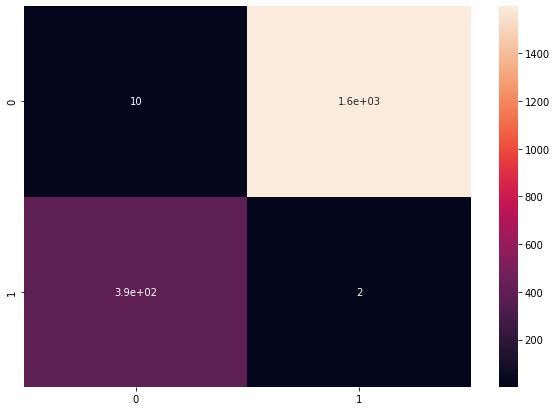

In [113]:
cm = confusion_matrix(y_test, model(X_test).round().eq(y_test))
df_cm = pd.DataFrame(cm)

plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [85]:
scaler = StandardScaler()
model = scaler.fit(train[feature_cols])
kf_x = model.transform(train[feature_cols])

In [86]:
score_lr = cross_val_score(LogisticRegression(), kf_x, train['Exited'].values, scoring='accuracy', cv = KFold(n_splits=5, shuffle = True, random_state= 42), n_jobs = -1)
print(f"Accuracy: {np.mean(score_lr)}")

Accuracy: 0.80975


In [118]:
kf = KFold(n_splits=5)

scores = []
for train_index, test_index in kf.split(x_,  y_):
    scaler = StandardScaler()
    X_train, X_test = scaler.fit_transform(x_.iloc[train_index]), scaler.transform(x_.iloc[test_index])
    y_train, y_test = y_[train_index], y_[test_index]

    X_train = torch.from_numpy(X_train.astype(np.float32))
    X_test = torch.from_numpy(X_test.astype(np.float32))
    y_train = torch.from_numpy(y_train.astype(np.float32))
    y_test = torch.from_numpy(y_test.astype(np.float32))

    y_train = y_train.view(len(y_train), 1)
    y_test = y_test.view(len(y_test), 1)

    y_pred = model(X_train)
    loss = criterion(input=y_pred, target=y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
        
    print(f"Loss: {round(loss.item(), 4)}")
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_class = y_pred.round()
        accuracy = y_pred_class.eq(y_test).sum() / float(len(y_test))
        print(f"Accuracy (on test-set): {round(accuracy.item(), 4)}")
        scores.append(accuracy)

print("KFold accuracy: ",np.mean(scores))

Loss: 0.6666
Accuracy (on test-set): 0.7915
Loss: 0.6562
Accuracy (on test-set): 0.785
Loss: 0.647
Accuracy (on test-set): 0.7985
Loss: 0.638
Accuracy (on test-set): 0.801
Loss: 0.6294
Accuracy (on test-set): 0.805
KFold accuracy:  0.79620004
